<a href="https://colab.research.google.com/github/dipucriodigital/ciencia-de-dados-e-analytics/blob/main/advanced-analytics/GANS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Redes Neurais Generativas Adversárias

Neste exemplo vamos implmentar uma GAN capaz de gerar algarismos baseada no dataset MNIST. Vamos implementar um gerador e um discriminador. Ao final do treino a partir de um vetor aleatório que podemos chamar de "ruído" o gerador deve ser capaz de gerar dígitos a partir dele. O objetivo do disriminador nessa arquitetura é justamente avaliar se uma imagem gerada pode ser validada ou não como um digito real. Portanto, no processo de treinamento o gerador "briga" contra o discrinador na tentativa de enganá-lo gerando imagens mais próximas do real.

In [ ]:
!pip3 install -q torch torchvision

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

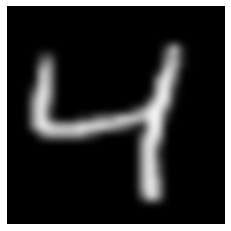

4
torch.Size([1, 28, 28])


In [ ]:
#Loading dataset
mnist_dataset = datasets.MNIST(root='../data', train=True, transform=transforms.ToTensor(), download=True)

def show(img,renorm=False,nrow=8,interpolation='bicubic'):
  if renorm:
    img = img/2 + 0.5
  img_grid = torchvision.utils.make_grid(img,nrow=nrow).numpy()
  plt.figure()
  plt.imshow(np.transpose(img_grid, (1,2,0)), interpolation=interpolation)
  plt.axis('off')
  plt.show()
  
image, label = mnist_dataset.__getitem__(2)
show(image)
print(label)
print(image.shape)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Generator_MNIST(nn.Module):
  
  def __init__(self, z_size=100, out_size=1, ngf=64):
    super(Generator_MNIST, self).__init__()
    self.z_size = z_size
    self.ngf = ngf
    self.out_size = out_size
    
    self.layer1 = nn.Sequential(## 1x1 to 4x4
        nn.ConvTranspose2d(self.z_size, self.ngf * 4, 4, 1, 0, bias=False),
        nn.BatchNorm2d(self.ngf * 4),
        nn.ReLU(inplace=True)
    )
    
    self.layer2 = nn.Sequential(## 4x4 to 7x7
        nn.ConvTranspose2d(self.ngf * 4, self.ngf * 2, 3, 2, 1, bias=False),
        nn.BatchNorm2d(self.ngf * 2),
        nn.ReLU(inplace=True)
    )
    
    self.layer3 = nn.Sequential(## 7x7 to 14x14
        nn.ConvTranspose2d(self.ngf * 2, self.ngf, 4, 2, 1, bias=False),
        nn.BatchNorm2d(self.ngf),
        nn.ReLU(inplace=True)
    )
    
    self.layer4 = nn.Sequential(## 14x14 to 28x28
        nn.ConvTranspose2d(self.ngf, self.out_size, 4, 2, 1, bias=False),
        nn.Tanh()
    )
    
  def initialize(self):
    for m in self.modules():
      if isinstance(m, nn.ConvTranspose2d):
        m.weight.data.normal_(0.0, 0.02)
        if m.bias is not None:
          m.bias.data.zero_()
    
  def forward(self, z):
    out = self.layer1(z)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    return out

In [ ]:
class Discriminator_MNIST(nn.Module):
  
  def __init__(self, in_size=1, ndf=64):
    super(Discriminator_MNIST, self).__init__()
    self.in_size = in_size
    self.ndf = ndf
    
    self.layer1 = nn.Sequential(## 28x28 to 14x14
      nn.Conv2d(self.in_size, self.ndf, 4, 2, 1, bias=False),
      nn.LeakyReLU(0.2, inplace=True)
    )
    
    self.layer2 = nn.Sequential(## 14x14 to 7x7
      nn.Conv2d(self.ndf, self.ndf * 2, 4, 2, 1, bias=False),
      nn.BatchNorm2d(self.ndf * 2),
      nn.LeakyReLU(0.2, inplace=True)
    )
    
    self.layer3 = nn.Sequential(## 7x7 to 4x4
      nn.Conv2d(self.ndf * 2, self.ndf * 4, 3, 2, 1, bias=False),
      nn.BatchNorm2d(self.ndf * 4),
      nn.LeakyReLU(0.2, inplace=True)
    )
    
    self.layer4 = nn.Sequential(## 4x4 to 1
      nn.Conv2d(self.ndf * 4, 1, 4, 1, 0, bias=False),
      nn.Sigmoid()
    )
    
  def initialize(self):
    for m in self.modules():
      if isinstance(m, nn.ConvTranspose2d):
        m.weight.data.normal_(0.0, 0.02)
        if m.bias is not None:
          m.bias.data.zero_()
    
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    return out

In [ ]:
from torch.utils.data import DataLoader

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def to_cuda(x):
    return x.to(DEVICE)

batch_size = 64
data_loader = DataLoader(dataset=mnist_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
epochs = 100
lr = 0.0002
z_dim = 100

D = to_cuda(Discriminator_MNIST())
G = to_cuda(Generator_MNIST())

criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=lr)
G_opt = torch.optim.Adam(G.parameters(), lr=lr)

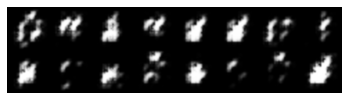

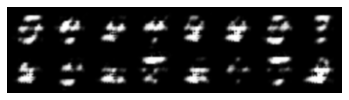

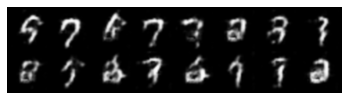

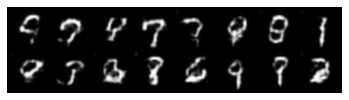

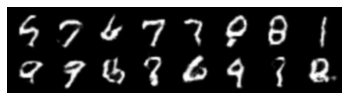

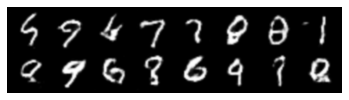

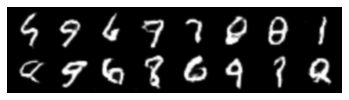

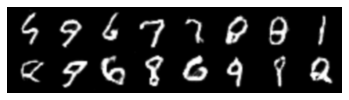

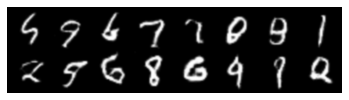

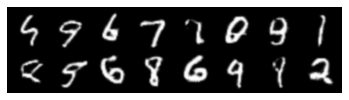

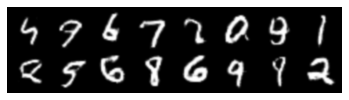

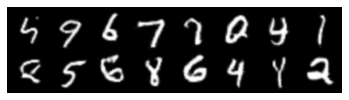

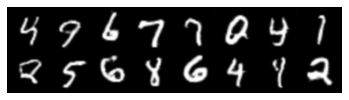

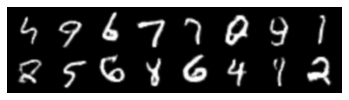

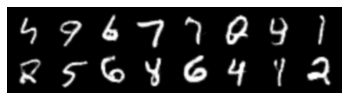

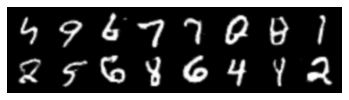

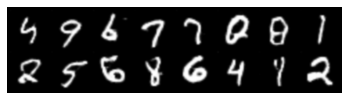

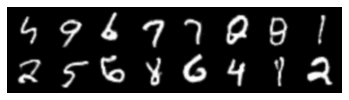

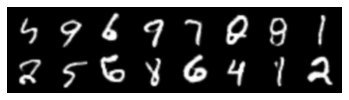

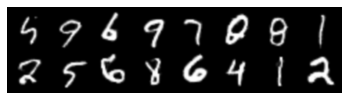

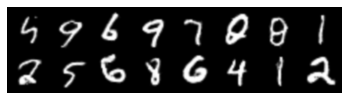

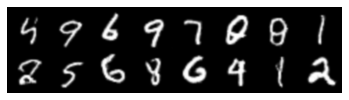

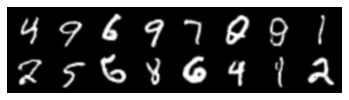

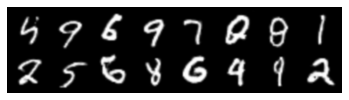

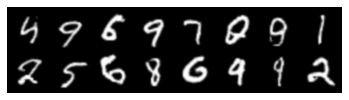

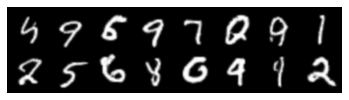

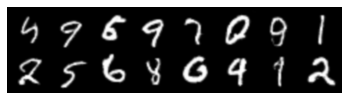

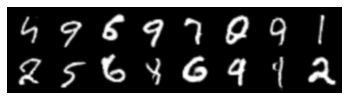

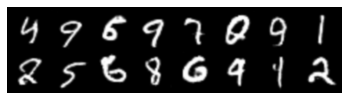

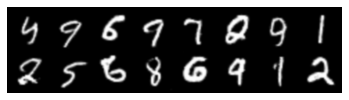

In [ ]:
fixed_noise = to_cuda(torch.randn(batch_size, z_dim).view(-1, 100, 1, 1))
n_critic = 1

D.initialize()
G.initialize()

step = 0
for epoch in range(epochs):
  for idx, (img_batch, _) in enumerate(data_loader):
    step += 1
    mbatch_size = img_batch.size()[0]
    D_labels = to_cuda(torch.ones(mbatch_size,1,1,1)) # Discriminator Label to real
    D_fakes = to_cuda(torch.zeros(mbatch_size,1,1,1)) # Discriminator Label to fake
    # Training Discriminator
    x = to_cuda(img_batch)
    x_disc = D(x)

    D_x_loss = criterion(x_disc, D_labels)

    z = to_cuda(torch.randn(mbatch_size, z_dim).view(-1, z_dim, 1, 1))
    z_disc = D(G(z))
    D_z_loss = criterion(z_disc, D_fakes)
    D_loss = D_x_loss + D_z_loss

    D.zero_grad()
    D_loss.backward()
    D_opt.step()
    
    if step % n_critic == 0:
      # Training Generator
      z = to_cuda(torch.randn(mbatch_size, z_dim).view(-1, z_dim, 1, 1))
      z_disc = D(G(z))
      G_loss = criterion(z_disc, D_labels)

      D.zero_grad()
      G.zero_grad()
      G_loss.backward()
      G_opt.step()
        
    if step % 1000 == 0:
      G.eval()
      fake = G(fixed_noise)
      imgs = fake.detach().cpu()
      show(imgs[0:16],nrow=8)
      G.train()

#Execício 1 - Gerando imagens de rostos

O **CelebFaces Attributes Dataset (CelebA)** é um conjunto de dados em grande escala que contém $\geq 200k$ imagens de rostos de celebridades, cada uma com $40$ de anotações de atributos. É um famoso conjunto de dados, que permite abordar questões complexas de síntese de imagens. Neste exercício vamos focar em tentar gerar aleatoriamente imagens semelhantes ao conjunto de dados, ou seja, gerar novas faces artificiais.

As imagens têm dimensões $178\times 218$ as quais são muito grandes para nossa tarefa, e para isso precisamos redimensioná-las para $64\times 64$. Isto é feito devido as limitações de hardware/memória e da complexidade de rede neural.

O código a seguir ajudará você a baixar e formatar o conjunto de dados.

In [ ]:
#download do dataset
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

In [ ]:
import zipfile

with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

In [ ]:
import os
root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

In [ ]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
import PIL.Image as Image
""" data """
crop_size = 108
re_size = 64
offset_height = (218 - crop_size) // 2
offset_width = (178 - crop_size) // 2
crop = lambda x: x[:, offset_height:offset_height + crop_size, offset_width:offset_width + crop_size]

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Lambda(crop),
     transforms.ToPILImage(),
     transforms.Scale(size=(re_size, re_size), interpolation=Image.BICUBIC),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)])

batch_size = 64
celeba_data = datasets.ImageFolder('./data_faces', transform=transform)
data_loader = DataLoader(celeba_data,batch_size=batch_size,shuffle=True)

In [ ]:
batch, _ = next(iter(data_loader))
show(batch[0:16], renorm = True, nrow=4)

**Crie um modelo de GAN convolucional que possa ser treinado em imagens 64x64x3. Isso deve ser fácil ao tomar o modelo MNIST fornecido como base.**

Treine este modelo GAN no conjunto de dados CelebA. Faça os ajustes necessários na rede para um melhor capacidade, ou seja, insira layers caso necessário. Altere o otimizador para RMSprop ou Gradiente descente estocástico. Compare os resultados com o otimizador ADAM.